In [15]:
import os 
import torch
from dataset import Comma10kDataset, train_test_split, get_test_transforms
import matplotlib.pyplot as plt 

In [6]:
comma10k_dir = "/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k"
imgs_root = os.path.join(comma10k_dir, "imgs")
masks_root = os.path.join(comma10k_dir, "masks")
classes = [41, 76, 90, 124, 161]

In [7]:
train_imgs, test_imgs = train_test_split(imgs_root)

In [8]:
len(test_imgs)

989

In [12]:
test_dataset = Comma10kDataset(imgs_root, masks_root, test_imgs, classes, get_test_transforms())

In [21]:
for img, mask in test_dataset:
    print(img.size())
    print(mask.size())
    break

torch.Size([3, 448, 576])
torch.Size([5, 448, 576])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


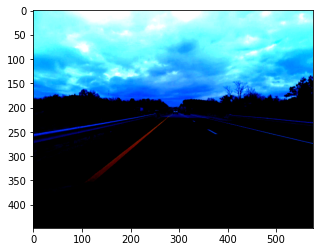

In [22]:
img = torch.transpose(img, 0, 2)
img = torch.transpose(img, 0, 1).numpy()
plt.imshow(img)

In [23]:
mask = mask.numpy()

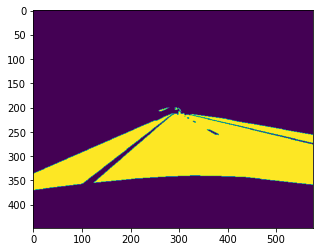

In [24]:
plt.imshow(mask[0])

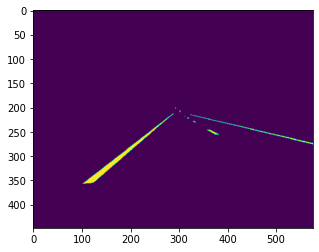

In [25]:
plt.imshow(mask[1])

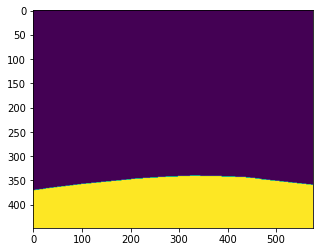

In [26]:
plt.imshow(mask[2])

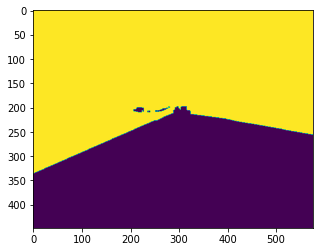

In [27]:
plt.imshow(mask[3])

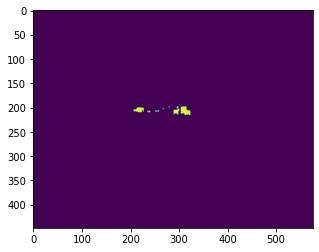

In [28]:
plt.imshow(mask[4])

# Test Model

In [19]:
import os 
import cv2
import random 
import glob 
import torch 
import torch.nn.functional as F
import numpy as np
from model import RegSeg
import matplotlib.pyplot as plt 

import albumentations as A 
from albumentations.pytorch import ToTensorV2

In [3]:
imgs_folder = "/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/imgs"
checkpoint = "/home/johann/sonstiges/comma10k-segmenation-pytorch/exps/2022-03-30/final.pth"
classes = [41, 76, 90, 124, 161]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
model = RegSeg(num_classes=len(classes))
model.load_state_dict(torch.load(checkpoint))
model.to(device)

RegSeg(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (d_block_1_4): DBlock(
      (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
      (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu3): ReLU(inplace=True)
      (conv4): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1))
      (bn4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [7]:
transform = A.Compose([
    A.Resize(height=14*32, width=18*32), #height, width
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2(),
])

In [10]:
test_imgs = glob.glob(imgs_folder + "/*.png")
samples = random.sample(test_imgs, 5)
for sample in samples:
    print(sample)

/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/imgs/0491_23fca19e46950b0a_2018-05-17--20-24-55_10_1069.png
/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/imgs/3128_b5e785c1fc446ed0_2018-08-27--06-22-47_14_1155.png
/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/imgs/6280_b29e3bc918751697_2019-06-05--15-17-52_11_627.png
/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/imgs/6491_098646b398495696_2019-01-22--14-36-13_3_1190.png
/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/imgs/7630_8443d7dd0ec9bd92_2019-01-08--16-50-00_13_933.png


In [22]:
def predict(model, img_path, transforms, device):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transformed_img = transforms(image=img)["image"]
    transformed_img = transformed_img.unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred = model(transformed_img)
    
    pred = torch.sigmoid(pred)
    pred = pred.detach().cpu().squeeze().numpy()
    
    return pred

In [71]:
pred_0 = predict(model, samples[0], transform, device)

In [72]:
classMap = np.argmax(pred_0, axis=0)
print(classMap.shape)

(448, 576)


In [73]:
colored_mask = colors[classMap]
colored_mask.shape

(448, 576, 3)

In [74]:
image = cv2.imread(samples[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(874, 1164, 3)

In [75]:
colored_mask = cv2.resize(colored_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
colored_mask.shape

(874, 1164, 3)

In [80]:
output = ((0.5 * image) + (0.5 * colored_mask)).astype("uint8")
output.shape

(874, 1164, 3)

(-0.5, 1163.5, 873.5, -0.5)

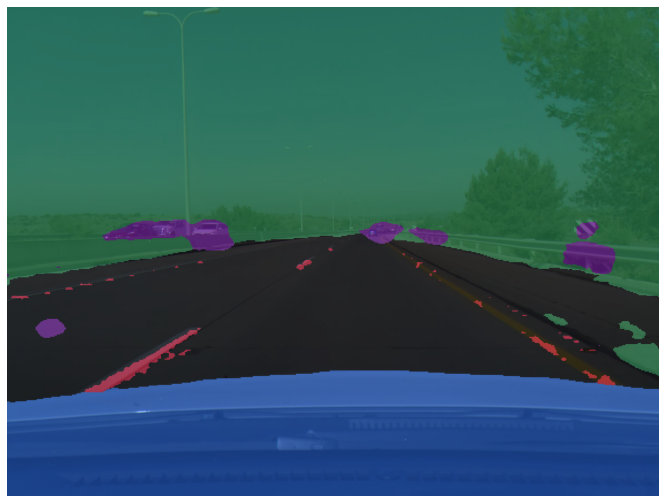

In [82]:
plt.figure(figsize=(16,9))
plt.imshow(output)
plt.axis("off")

In [96]:
def plot_segmentation(
    model, 
    img_path, 
    classes,
    transforms, 
    device, 
    figsize=(16,9),
    img_weight=0.5,
):
    pred = predict(model, img_path, transforms, device)
    classMap = np.argmax(pred, axis=0)
    
    # pick some random colors
    np.random.seed(42)
    colors = np.random.randint(0, 255, size=(len(classes) - 1, 3), dtype="uint8")
    colors = np.vstack([[0, 0, 0], colors]).astype("uint8")
    
    colored_mask = colors[classMap]
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    colored_mask = cv2.resize(
        colored_mask, 
        (image.shape[1], image.shape[0]), 
        interpolation=cv2.INTER_NEAREST,
    )
    
    output = ((img_weight * image) + ((1. - img_weight) * colored_mask)).astype("uint8")
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(output)

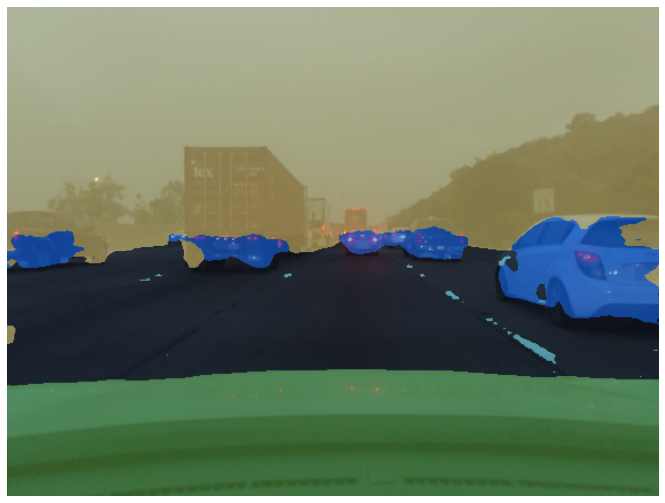

In [97]:
plot_segmentation(model, samples[1], classes, transform, device)

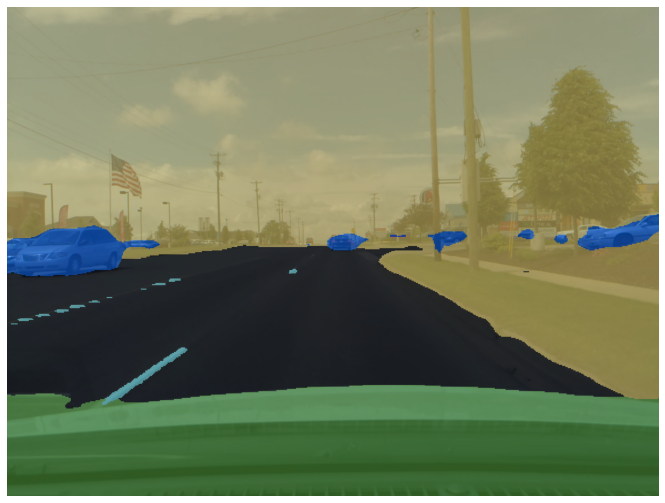

In [98]:
plot_segmentation(model, samples[2], classes, transform, device)

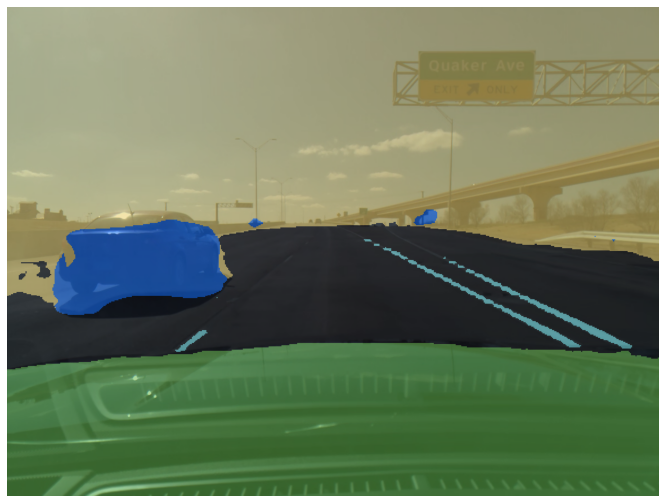

In [99]:
plot_segmentation(model, samples[3], classes, transform, device)

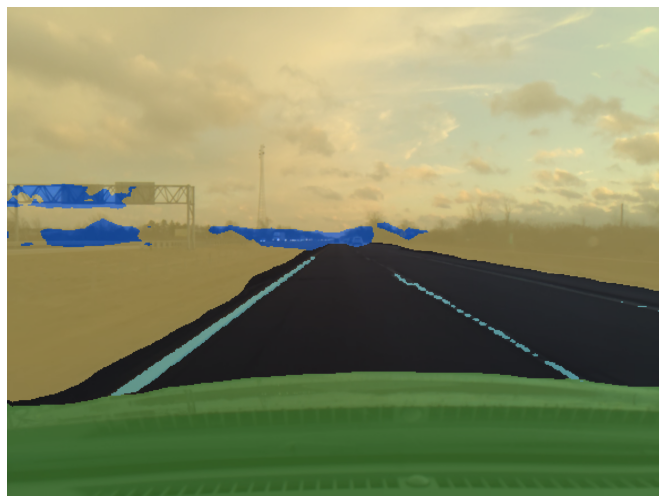

In [100]:
plot_segmentation(model, samples[4], classes, transform, device)

In [48]:
pred_0 = (pred_0 >= 0.5).astype(int)

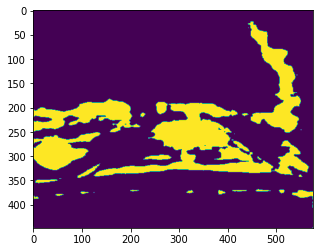

In [53]:
plt.imshow(pred_0[4])

In [54]:
for i, cl in enumerate(classes):
    pred_0[i] = pred_0[i] * cl

In [60]:
colors = np.random.randint(0, 255, size=(len(classes) - 1, 3), dtype="uint8")
colors = np.vstack([[0, 0, 0], colors]).astype("uint8")
colors

array([[  0,   0,   0],
       [246,  25,  63],
       [ 47, 119, 252],
       [ 46, 162,  89],
       [140,  33, 190]], dtype=uint8)

In [44]:
test = pred_0[0]
mask = (test >= 0.5).astype(int)

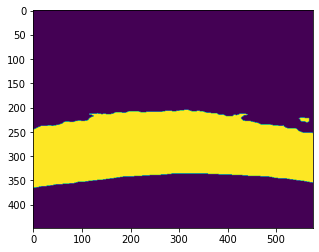

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

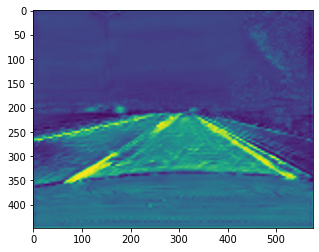